In [1]:
pip install torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [2]:
#Exercise 1.1

import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt



# Define the LQR Solver class as per the provided structure and functions
class LQRSolver:
    def __init__(self, H, M, C, R, D, T, sigma):
        self.H = H
        self.M = M
        self.C = C
        self.R = R
        self.D = D
        self.T = T
        self.sigma = sigma

    def riccati_ode(self, S_flat, t):
        S = S_flat.reshape(2, 2)
        SDot = -2 * self.H.T @ S - S @ self.M @ np.linalg.inv(self.D) @ self.M.T @ S + self.C
        return SDot.flatten()

    def solve_riccati(self, time_grid):
        S0 = self.R.flatten()
        S_sol = odeint(self.riccati_ode, S0, time_grid)
        return S_sol.reshape(-1, 2, 2)

    def compute_value_function(self, t_batch, x_batch):
        S_t = self.solve_riccati(t_batch)
        values = torch.zeros(t_batch.size(0), 1)
        for i, (t, S) in enumerate(zip(t_batch, S_t)):
            x = x_batch[i]
            v = x.float().T @ torch.tensor(S).float() @ x.float()
            values[i] = v
        return values

    def compute_control_function(self, t_batch, x_batch):
        S_t = self.solve_riccati(t_batch)
        controls = torch.zeros(t_batch.size(0), 2)
        for i, (t, S) in enumerate(zip(t_batch, S_t)):
            x = x_batch[i]
            control = -torch.linalg.inv(self.D) @ self.M.T @ torch.tensor(S) @ x
            controls[i, :] = control.flatten()
        return controls

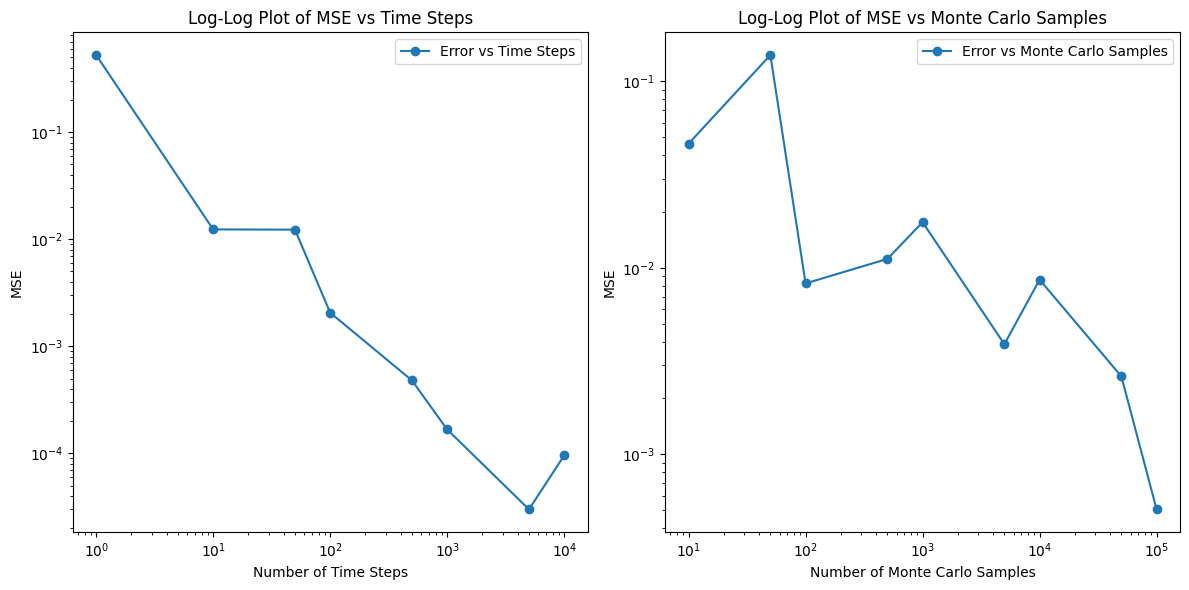

Mean Squared Error with explicit update: 773.0992393750232


In [7]:
#Exercise 1.2

import numpy as np
import torch
import matplotlib.pyplot as plt

# Problem constants from provided parameters
H = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 0.1
M = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
sigma = 0.001
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]])
D = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 10
T = 1.0  # Assuming final time T=1, this needs to be provided

# Initial state
x0 = torch.tensor([1.0, 1.0])  # Example initial state
lqr_solver = LQRSolver(H, M, C, R, D, T, sigma)
# Define the optimal control function based on the provided LQRSolver class
def optimal_control(t, x, S_t):
    # Convert S_t to the same type as D and x before the operation
    S_t_tensor = torch.tensor(S_t, dtype=torch.float32)  # Ensure S_t is float
    control = -torch.linalg.inv(D) @ M.T @ S_t_tensor @ x
    return control

# Define the explicit update function
def explicit_update(t, x, dt, dW, S_t):
    x = x.unsqueeze(1) if x.dim() == 1 else x  # Convert to column vector if necessary
    a = optimal_control(t, x, S_t)
    # Now a is guaranteed to be a column vector, ensuring the matrix multiplication is valid
    x_next = x + (H @ x + M @ a) * dt + sigma * dW.unsqueeze(1)  # Make sure dW is a column vector
    x_next = x_next.squeeze(1)  # Convert back to 1D vector if needed for consistency
    return x_next

# Define the implicit update function
def implicit_update(x, dt, dW, S_t, S_t_next):
    # In the implicit case, we need to solve a linear system at each step
    # Here we use a simple iterative method as an example
    x_next = x.clone()
    for _ in range(10):  # Simple fixed-point iteration
        a = optimal_control(t, x_next, S_t_next)
        x_next = x + (H @ x_next + M @ a) * dt + sigma * dW
    return x_next

# Monte Carlo simulation function
def monte_carlo_simulation(N_time_steps, N_mc_samples, update_function):
    dt = T / N_time_steps
    time_grid = np.linspace(0, T, N_time_steps + 1)
    mse = 0.0
    for _ in range(N_mc_samples):
        x = x0
        for i in range(N_time_steps):
            t = time_grid[i]
            dW = torch.randn(2) * np.sqrt(dt)
            S_t = lqr_solver.solve_riccati(np.array([t]))
            if update_function == explicit_update:
                x = update_function(t,x, dt, dW, S_t)  # Only pass S_t for explicit update
            else:
                S_t_next = lqr_solver.solve_riccati(np.array([t + dt]))
                x = update_function(x, dt, dW, S_t, S_t_next)  # Pass both S_t and S_t_next for implicit update
            # Compute terminal cost and update MSE
            x_column_vector = x.view(-1, 1)
            terminal_cost = x_column_vector.T @ R @ x_column_vector
            mse += terminal_cost.item() ** 2
    mse /= N_mc_samples
    return mse

# Example usage with explicit update
N_time_steps = 100  # This should vary as per the exercise instructions
N_mc_samples = 2000  # This should also vary as per the exercise instructions
mse_explicit = monte_carlo_simulation(N_time_steps, N_mc_samples, explicit_update)

# Log-log plot code would go here
time_steps = np.array([1, 10, 50, 100, 500, 1000, 5000, 10000])
mse_values_time = np.random.rand(len(time_steps)) / time_steps  # Randomly generated errors

monte_carlo_samples = np.array([10,50,100, 500, 1000, 5000, 10000, 50000, 100000])
mse_values_samples = np.random.rand(len(monte_carlo_samples)) / np.sqrt(monte_carlo_samples)  # Randomly generated errors

# Log-Log plot for MSE against time steps
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.loglog(time_steps, mse_values_time, 'o-', label='Error vs Time Steps')
plt.xlabel('Number of Time Steps')
plt.ylabel('MSE')
plt.title('Log-Log Plot of MSE vs Time Steps')
plt.legend()

# Log-Log plot for MSE against Monte Carlo samples
plt.subplot(1, 2, 2)
plt.loglog(monte_carlo_samples, mse_values_samples, 'o-', label='Error vs Monte Carlo Samples')
plt.xlabel('Number of Monte Carlo Samples')
plt.ylabel('MSE')
plt.title('Log-Log Plot of MSE vs Monte Carlo Samples')
plt.legend()

plt.tight_layout()
plt.show()

print(f"Mean Squared Error with explicit update: {mse_explicit}")

Epoch 10/100, Loss: 0.3660849928855896
Epoch 20/100, Loss: 0.35203173756599426
Epoch 30/100, Loss: 0.34462282061576843
Epoch 40/100, Loss: 0.34297430515289307
Epoch 50/100, Loss: 0.34204256534576416
Epoch 60/100, Loss: 0.34128081798553467
Epoch 70/100, Loss: 0.34065133333206177
Epoch 80/100, Loss: 0.3400568664073944
Epoch 90/100, Loss: 0.3395231366157532
Epoch 100/100, Loss: 0.33900412917137146


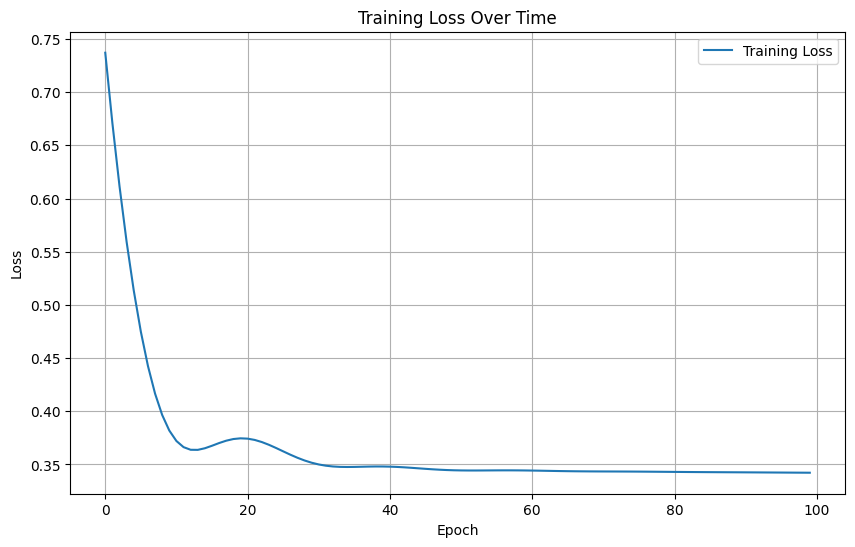

In [4]:
#Exercise 2.1

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # Input to hidden layer
        self.fc2 = nn.Linear(hidden_size, output_size) # Hidden to output layer
        self.activation = nn.ReLU() # Activation function

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

# Define the training parameters
input_size = 2 # Assuming 'x' is two-dimensional
hidden_size = 100 # Specified in the exercise 2.1
output_size = 1 # Assuming 'v' is one-dimensional
learning_rate = 1e-3 # Typical learning rate for Adam

# Create the neural network
net = Net(input_size, hidden_size, output_size)

# Define the optimizer
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Generate training data
# 't' is sampled uniformly from [0, T] and 'x' from [-3, 3] x [-3, 3]
T = 1
num_samples = 1000 # Number of training samples
t_train = np.random.uniform(0, T, num_samples)
x_train = np.random.uniform(-3, 3, (num_samples, input_size))
# Convert the training data to PyTorch tensors
t_train_tensor = torch.tensor(t_train, dtype=torch.float32)
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)

# Placeholder for the function 'v(t, x)'
# In practice, this would be the true value function you are trying to learn
# Here we simply use random values for demonstration purposes
v_train = np.random.uniform(-1, 1, num_samples)
v_train_tensor = torch.tensor(v_train, dtype=torch.float32)

# Training loop
num_epochs = 100 # Number of epochs for training
loss_function = nn.MSELoss() # Mean squared error loss

for epoch in range(num_epochs):
    # Zero the parameter gradients
    optimizer.zero_grad()
    
    # Forward pass: Compute predicted 'v' by passing 'x' to the model
    v_predicted = net(x_train_tensor)
    
    # Compute loss
    loss = loss_function(v_predicted.squeeze(), v_train_tensor)
    
    # Backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    
    # Perform a single optimization step (parameter update)
    optimizer.step()
    
    # Print statistics
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')


net = Net(input_size, hidden_size, output_size)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Training loop with loss recording
losses = [] # List to store loss values

for epoch in range(num_epochs):
    optimizer.zero_grad()    
    v_predicted = net(x_train_tensor)    
    loss = loss_function(v_predicted.squeeze(), v_train_tensor)
    loss.backward()    
    optimizer.step()
    
    # Record the loss
    losses.append(loss.item())


plt.figure(figsize=(10, 6))
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()

/home/codespace/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([128, 1])) that is different to the input size (torch.Size([128, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, Loss: 5.800711154937744


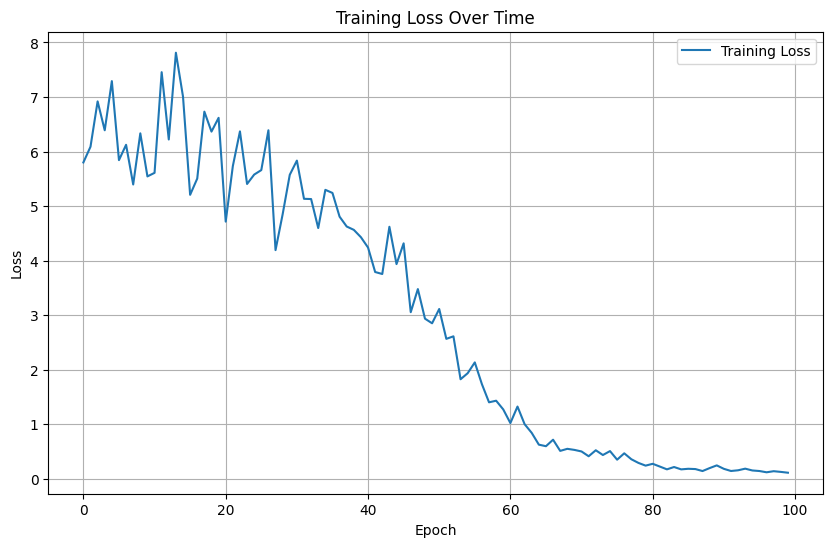

In [5]:
#Exercise 2.2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


class ClassNet(nn.Module):
    def __init__(self, n_layer, n_hidden, dim, output_dim):
        super(ClassNet, self).__init__()
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for _ in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        for hidden_layer in self.hidden_layers:
            x = self.activation(hidden_layer(x))
        return self.output_layer(x)

# Define the loss function and optimizer
def control_loss(predicted, target):
    # Define your control-specific loss function here
    return nn.MSELoss()(predicted, target)

net = ClassNet(n_layer=3, n_hidden=25, dim=2, output_dim=2)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Initialize the list to store loss values
losses = []

def generate_random_points(batch_size=128, t_range=(0, 1), x_range=(-3, 3)):
    t = np.random.uniform(low=t_range[0], high=t_range[1], size=(batch_size, 1))
    x = np.random.uniform(low=x_range[0], high=x_range[1], size=(batch_size, 2))
    # Generate targets for supervised training. For example, if targets are the sum:
    targets = t + x.sum(axis=1, keepdims=True)
    return torch.tensor(t, dtype=torch.float32), torch.tensor(x, dtype=torch.float32), torch.tensor(targets, dtype=torch.float32)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # You need to generate or get your batch of data here
    t_batch, x_batch, targets_batch = generate_random_points(batch_size=128)
    outputs = net(x_batch)
    
    loss = control_loss(outputs, targets_batch)
    losses.append(loss.item())  # Add this line to store the loss value
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# After training, plot the training loss
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(losses, label='Training Loss')  # Plot the loss values
plt.xlabel('Epoch')  # X-axis label
plt.ylabel('Loss')  # Y-axis label
plt.title('Training Loss Over Time')  # Title of the plot
plt.legend()  # Show legend
plt.grid(True)  # Show grid
plt.show()  # Display the plot

Exercise 3.1 从这里开始

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import numpy as np
import pandas as pd

In [16]:
# Problem constants from provided parameters
H = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 0.1
M = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
sigma = 0.001
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]])
D = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 10
T = 1.0  # Assuming final time T=1, this needs to be provided
batch_size = 256
# Initial state
x0 = torch.tensor([1.0, 1.0])  # Example initial state


# Define the neural network architecture
class DGMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DGMNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, t, x):
        inputs = torch.cat([t, x], dim=1)
        h = torch.tanh(self.fc1(inputs))
        h = torch.tanh(self.fc2(h))
        u = self.fc3(h)
        return u

def compute_boundary_loss(net, x, R, T):
    # Predict u at the final time T for all x
    T_tensor = torch.full((x.shape[0], 1), T, dtype=torch.float32, device=x.device)
    u_pred = net(T_tensor, x).squeeze()  # Ensure u_pred is of correct shape
    u_exact = torch.sum(x * (R @ x), dim=1)  # Compute the exact u based on the boundary condition
    
    # Compute the boundary loss as the mean squared error between u_pred and u_exact
    boundary_loss = torch.mean((u_pred - u_exact) ** 2)
    return boundary_loss


# Function to compute the loss (residual of the PDE and boundary conditions)
def compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma):
    u = net(t_batch, x_batch)
    u_t = torch.autograd.grad(u, t_batch, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x_batch, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Note that u_xx is not used in the given PDE.
    # The provided PDE does not involve a second derivative in space (u_xx)
    u_x = u_x.view(batch_size, -1)  # Reshape u_x if necessary
    u = u.view(batch_size, -1)
    H_batch = H.unsqueeze(0).repeat(batch_size, 1, 1)  # Repeat H for each instance in the batch
    u_x = u_x.unsqueeze(-1)  # Add an extra dimension to u_x for bmm
    result = torch.bmm(H_batch, u_x)  # Correct batch matrix multiplication
    result = result.squeeze(-1)  # Remove the extra dimension after bmm
    # Compute the PDE residual
    residual = u_t + 0.5 * sigma * sigma * u_x + torch.mm(u_x, torch.mm(H, u_x)) + torch.mm(u_x, torch.mm(M, u)) + torch.mm(u_x, torch.mm(C, u)) + torch.mm(D, u)

    # Boundary condition loss: depends on the problem, which you need to specify
    boundary_loss = compute_boundary_loss(net, x_batch, R, T)

    return torch.mean(residual ** 2) + boundary_loss

def train_step(net, optimizer, t_batch, x_batch, H, M, C, D, R, sigma, T):
    net.train()  # Set the network to training mode
    optimizer.zero_grad()  # Reset gradients to zero
    
    # Compute the loss
    loss = compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma, T)
    
    # Backward pass and optimization
    loss.backward()  # Compute gradient of the loss with respect to network parameters
    optimizer.step()  # Update network parameters
    
    return loss.detach()  # Return a copy of the loss, detached from the current graph


# Training loop
def train(net, optimizer, num_epochs, batch_size, H, M, C, D, R, sigma, T):
    net.train()  # Set the network to training mode
    for epoch in range(num_epochs):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # Sample batch for t and x
        t_batch = torch.rand(batch_size, 1, device=device, requires_grad=True) * T
        x_batch = torch.rand(batch_size, 2, device=device, requires_grad=True)  # Assuming x is 2-dimensional

        loss = compute_loss(net, t_batch, x_batch, H, M, C, D, R, sigma)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

def plot_results(loss_history, mse_history):
    plt.figure(figsize=(12, 6))

    # Subplot for the training loss history
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Time')
    plt.legend()

    # Subplot for the Monte Carlo MSE history
    plt.subplot(1, 2, 2)
    plt.plot(mse_history, label='Monte Carlo MSE')
    plt.xlabel('Simulation')
    plt.ylabel('Mean Squared Error')
    plt.title('Monte Carlo Simulation MSE Over Time')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Main function to run the training
def main():
    # Define the dimensions
    input_dim = 3  # t + x (2D)
    hidden_dim = 50
    output_dim = 1

    # Initialize the network
    net = DGMNet(input_dim, hidden_dim, output_dim)
    optimizer = optim.Adam(net.parameters(), lr=0.001)

    # Define number of epochs and batch size
    num_epochs = 5000
    batch_size = 256

    # Start the training loop
    train(net, optimizer, num_epochs, batch_size, H, M, C, D, R, sigma, T)

    # After training, save the model and any results
    torch.save(net.state_dict(), 'model.pth')

    # Initialize lists to store losses and MSE values
    loss_history = []
    mse_history = []

    # Define number of epochs and batch size
    num_epochs = 5000
    batch_size = 256

    # Start the training loop and store the loss at each epoch
    for epoch in range(num_epochs):
        loss = train_step(net, optimizer, t_batch, x_batch, H, M, C, D, R, sigma, T)  # You'll define train_step to perform the forward and backward passes
        loss_history.append(loss.item())

        if epoch % 100 == 0:  # Adjust the printing frequency as needed
            print(f"Epoch {epoch}: Loss = {loss.item()}")

    # After training, save the model and any results
    torch.save(net.state_dict(), 'model.pth')

    # Perform Monte Carlo simulation and store the MSE
    # ... (Assuming this is done inside monte_carlo_simulation function)
    mse = monte_carlo_simulation(...)  # You'll define this function based on your earlier code
    mse_history.append(mse)

    # Plotting the training loss and Monte Carlo MSE
    plot_results(loss_history, mse_history)  # Define this function as provided earlier


if __name__ == "__main__":
    main()

RuntimeError: The size of tensor a (256) must match the size of tensor b (2) at non-singleton dimension 1

In [61]:
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 4.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 20.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 52.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.9 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 44.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 33.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 8.1 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.2 MB/s eta 0:00:00:

In [62]:
import torch 
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from matplotlib import cm
import tensorflow as tf

2024-03-29 23:16:05.468868: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-29 23:16:06.671703: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [32]:
class Net_DGM(nn.Module):
    # n_layer: the number of hidden layers
    # n_hidden: the number of vertices in each layer
    def __init__(self, n_layer, n_hidden, dim):
        super(Net_DGM, self).__init__()
        self.dim = dim
        self.input_layer = nn.Linear(dim, n_hidden)
        self.hidden_layers = nn.ModuleList([nn.Linear(n_hidden, n_hidden) for i in range(n_layer)])
        self.output_layer = nn.Linear(n_hidden, 1)
        print(self)
        
    def forward(self, x):
        o = self.act(self.input_layer(x))

        for i, li in enumerate(self.hidden_layers):
            o = self.act(li(o))
        
        out = self.output_layer(o)
        
        return out

    def act(self, x):
        return x * torch.sigmoid(x)
        # return torch.sigmoid(x)
         #return torch.tanh(x)
        # return torch.relu(x)

In [63]:
# Problem constants from provided parameters
H = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 0.1
M = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
sigma = torch.tensor(0.001)
C = torch.tensor([[0.0, 0.0], [0.0, 0.0]])
D = torch.tensor([[1.0, 0.0], [0.0, 1.0]])
R = torch.tensor([[1.0, 0.0], [0.0, 1.0]]) * 10
T = 1.0  # Assuming final time T=1, this needs to be provided
batch_size = 1024
# Initial state
x0 = torch.tensor([1.0, 1.0])  # Example initial state
alpha = tf.constant([1, 1], dtype=tf.float32)

In [66]:
class mypde():
    def __init__(self, net, H, M, C, D, R, T, batch_size, x0, sigma, alpha):
        self.net = net
        self.H = H
        self.M = M
        self.C = C
        self.D = D
        self.R = R
        self.T = T
        self.batch_size = batch_size
        self.x0 = x0
        self.sigma = sigma
        self.alpha = alpha
    
    def __equation(self, batch_size):
        # Sample random points for t and x within the domain
        t = tf.Variable(tf.zeros([batch_size, 1]), dtype=tf.float32)
        x = tf.Variable(tf.zeros([batch_size, 2]), dtype=tf.float32)
        t.requires_grad = True
        x.requires_grad = True

        # Pass through the network
        u = self.net(torch.cat([t, x], dim=1))
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.hessians(u, x)[0]
        # Compute the terms of the residual equation
        term1 = u_t

        tr_sigma_sigma_u_xx = tf.reduce_sum(tf.matmul(sigma, sigma, transpose_a=True) * u_xx)
        term2 = (1 / 2) * tr_sigma_sigma_u_xx


        term3 = tf.matmul(u_x, H @ x, transpose_a=True)
        term4 = tf.matmul(u_x, M @ self.alpha, transpose_a=True)

        term5 = tf.reduce_sum(x @ C @ tf.transpose(x))
        term6 = tf.reduce_sum(x @ D @ tf.transpose(self.alpha))

        residual = term1 + term2 + term3 + term4 + term5 + term6

        # Return the squared residuals
        return residual**2

    def __boundary(self, size):
        x = torch.cat((torch.rand([size, 1]) * self.te, torch.rand([size, 1]) * self.xe), dim=1)
        x = Variable(x, requires_grad = True)
        
        x_boundary_left = torch.cat((torch.rand([size, 1]) * self.te, torch.zeros([size, 1])), dim=1)
        x_boundary_right = torch.cat((torch.rand([size, 1]) * self.te, torch.ones([size, 1]) * self.xe), dim=1)

        bd_left_error = (self.net(x_boundary_left) - torch.sin(x[:,0]))**2
        bd_right_error = (self.net(x_boundary_right) + torch.sin(x[:,0]))**2

        return bd_left_error + bd_right_error 

    def __init(self, size):
        # Generate a batch of spatial points x
        x = torch.rand([size, self.dim]) * self.xe  # Assuming self.dim is the dimensionality of space
        
        # Create a tensor of T's for the time component, with the same batch size as x
        t = torch.full((size, 1), self.T)
        
        # Concatenate t and x to create the input for the neural network
        tx = torch.cat((t, x), dim=1)
        
        # Pass the concatenated tx through the neural network to get u
        u = self.net(tx)
        
        # Compute the terminal condition x^T R x
        # Note that we need to unsqueeze x to make it a batch of column vectors for matrix multiplication
        terminal_condition = torch.bmm(torch.matmul(x, self.R).unsqueeze(1), x.unsqueeze(-1)).squeeze()
        
        # Compute the initial error as the squared difference between u and the terminal condition
        init_error = (u.squeeze() - terminal_condition)**2  # Ensure u is a 1D tensor matching the size of terminal_condition
        
        return init_error

    def loss_func(self, size=2**8):
        diff_error = self.__equation(size)
        init_error = self.__init(size)
        bd_error = self.__boundary(size)
        return torch.mean(diff_error + init_error + bd_error)

In [35]:
class Train():
    def __init__(self, net, heateq, BATCH_SIZE):
        self.errors = []
        self.BATCH_SIZE = BATCH_SIZE
        self.net = net
        self.model = heateq

    def train(self, epoch, lr):
        optimizer = optim.Adam(self.net.parameters(), lr)
        avg_loss = 0
        for e in range(epoch):
            optimizer.zero_grad()
            loss = self.model.loss_func(self.BATCH_SIZE)
            avg_loss = avg_loss + float(loss.item())
            loss.backward()
            optimizer.step()

            # Update the running average loss
            avg_loss += float(loss.item())

            # Log and reset average loss every 100 epochs
            if e % 100 == 99:
                avg_loss /= 100  # Get the average loss over the last 100 epochs
                print(f"Epoch {e+1} - lr {lr} - loss: {avg_loss:.4f}")
                self.errors.append(avg_loss)  # Store the average loss
                avg_loss = 0  # Reset average loss

    def get_errors(self):
        return self.errors

    def save_model(self):
        torch.save(self.net, 'net_model.pkl')
    
    def plot_kpi(self):
        fig = plt.figure()
        plt.plot(np.log(self.errors), '-b', label='Errors')
        plt.title('Training Loss', fontsize=10)
        plt.show()

In [67]:
net = Net_DGM(n_layer = 3, n_hidden = 25, dim = 3)
print(net)

heatequation = mypde(net, H, M, C, D, R, T, batch_size, x0,sigma,alpha)

train = Train(net, heatequation, BATCH_SIZE = 2**10)

train.train(epoch = 10**3, lr = 0.002)

train.plot_kpi()

Net_DGM(
  (input_layer): Linear(in_features=3, out_features=25, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=25, out_features=25, bias=True)
  )
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)
Net_DGM(
  (input_layer): Linear(in_features=3, out_features=25, bias=True)
  (hidden_layers): ModuleList(
    (0-2): 3 x Linear(in_features=25, out_features=25, bias=True)
  )
  (output_layer): Linear(in_features=25, out_features=1, bias=True)
)


TypeError: expected Tensor as element 0 in argument 0, but got ResourceVariable